In [1]:
import os
import sys
import yaml
import copy
import warnings
import importlib as imp
from datetime import datetime
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# import pcl
import pyntcloud

sys.path.append('/home/jovyan/work/obstacle-detection/')

In [2]:
with open('../config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [3]:
# Segments id -> name mapping
seg_lst = config['segments']

In [4]:
# Obstacles id -> name mapping
obstacle_lst = config['obstacles']
obstacle_lst

{10: 'car',
 11: 'bicycle',
 13: 'bus',
 15: 'motorcycle',
 16: 'on-rails',
 18: 'truck',
 20: 'other-vehicle',
 30: 'person',
 31: 'bicyclist',
 32: 'motorcyclist',
 252: 'moving-car',
 253: 'moving-bicyclist',
 254: 'moving-person',
 255: 'moving-motorcyclist',
 256: 'moving-on-rails',
 257: 'moving-bus',
 258: 'moving-truck',
 259: 'moving-other-vehicle'}

In [5]:
num ='066'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

In [6]:
label = [seg & 0xFFFF for seg in label]
unq = list(set(label))
print('Scan have:')
for seg in unq:
    if seg in list(seg_lst.keys()):
        print(seg, seg_lst[seg])

Scan have:
0 unlabeled
1 outlier
99 other-object
70 vegetation
71 trunk
72 terrain
40 road
10 car
11 bicycle
44 parking
80 pole
81 traffic-sign
50 building
51 fence
48 sidewalk
20 other-vehicle


In [8]:
pcloud = pd.DataFrame(scan[:, :3], columns=['x', 'y', 'z'])
pcloud = pyntcloud.PyntCloud(pcloud)
pcloud.plot(use_as_color='seg_id', cmap="cool", backend="pythreejs")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.14305366575717926, 59.59479224681854, 3.6…

In [166]:
# pcloud.plot(use_as_color='camera', cmap="cool")

In [294]:
# is_parking = ~test_cloud.points['seg_id'].isin(list(obstacle_lst.keys()))
# test_cloud.points['is_parking'] = pd.Series(is_parking)

In [167]:
# test_cloud.plot(use_as_color='is_parking', cmap="RdYlGn", output_name="is_parking")

In [168]:
# is_parking = test_cloud.points['is_parking'] != 1
# test_cloud.apply_filter(is_parking)

In [169]:
# test_cloud.plot()

In [90]:
# n_voxels = 45
# voxelgrid_id = test_cloud.add_structure("voxelgrid", n_x=n_voxels, n_y=n_voxels, n_z=10)

In [170]:
# %time cluster_id = test_cloud.add_scalar_field("euclidean_clusters",voxelgrid_id=voxelgrid_id)

In [171]:
# test_cloud.plot(use_as_color=cluster_id, cmap="cool")

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from pipeline import common
common = imp.reload(common)

In [45]:
def pipeline(scan, label, obstacle_lst, verbose=False, exec_time=False, **params):
    
    # ROI filtering
    start_time = datetime.now()
    pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), 
                                                    columns=['x', 'y', 'z', 'seg_id'])
    pcloud = common.roi_filter(pcloud,  min_x=params['roi_x_min'], max_x=params['roi_x_max'], 
                                                min_y=params['roi_y_min'], max_y=params['roi_y_max'],
                                                min_z=params['roi_z_min'], max_z=params['roi_z_max'], 
                                                verbose=False)
    roi_time = (datetime.now() - start_time).total_seconds()
    
    # Obstacles filtering
    start_time = datetime.now()
    pcloud = common.obstacle_filter(pcloud, obstacle_lst, proc_labels=True, verbose=False)
    obstacle_time = (datetime.now() - start_time).total_seconds()
    
    if len(pcloud) > 200:
        
        # Getting voxel grid
        start_time = datetime.now()
        voxel_time = (datetime.now() - start_time).total_seconds()

        # Сlustering obstacles
        start_time = datetime.now()
        clusterer = DBSCAN(eps=params['eps'], min_samples=params['min_samples'], 
                           algorithm='kd_tree', leaf_size=params['leaf_size'])
        clusterer.fit(pcloud[['x', 'y', 'z']])
        pcloud['cluster_id'] = clusterer.labels_
        cluster_time = (datetime.now() - start_time).total_seconds()
        
        # Getting cluster min max points fot bounding boxes
        start_time = datetime.now()
        pcloud['norm'] = np.sqrt(np.square(pcloud[['x', 'y', 'z']]).sum(axis=1))
        cluster_data = pd.DataFrame.from_dict({'x': [], 'y': [], 'z': [],'cluster_id': []})
        for _id in pcloud['cluster_id'].unique():
            if _id == -1 or len(pcloud[pcloud['cluster_id'] == _id]) < 10:
                continue
            tcluster = common.outlier_filter(pcloud[pcloud['cluster_id'] == _id], verbose=False)
#             tcluster = common.get_rotated_data(tcluster)
            cluster_data = cluster_data.append(tcluster)
        clusters = cluster_data.groupby(['cluster_id']).agg({ 'x': ['min', 'max'],
                                                              'y': ['min', 'max'],
                                                              'z': ['min', 'max'] }).values
        min_max_time = (datetime.now() - start_time).total_seconds()
    else:
        clusters, cluster_data = np.empty((0, 0)), np.empty((0, 0))
        voxel_time, cluster_time, min_max_time = 0, 0, 0
        
    if verbose:
        print('Execution time:')
        print('\n - ROI filtering: {:.5f}s'.format(roi_time))
        print('\n - Filtering obstacles: {:.5f}s'.format(obstacle_time))
        print('\n - Voxel grid: {:.5f}s'.format(voxel_time))
        print('\n - Clustering: {:.5f}s'.format(cluster_time))
        print('\n - Min-max cluster points: {:.5f}s \n'.format(min_max_time))
        
    if exec_time:
        return clusters, cluster_data, {'roi_time': roi_time,
                                        'filter_obstacle_time': obstacle_time,
                                        'voxel_grid_time': voxel_time,
                                        'clustering_time': cluster_time,
                                        'outlier_filter_bbox_time': min_max_time}
    else:
        return clusters, cluster_data

## Pipeline implementation

In [46]:
%time 
num='073'
scan = np.fromfile('../dataset/sequences/00/velodyne/000' + num + '.bin', dtype=np.float32)
scan = scan.reshape((-1, 4))[:, :3]

label = np.fromfile('../dataset/sequences/00/labels/000' + num + '.label', dtype=np.uint32)
label = label.reshape((-1))

Wall time: 0 ns


{
   "eps": 0.65,
   "leaf_size": 100,
   "min_samples": 6,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 14,
   "roi_y_min": -14,
   "roi_z_max": 1,
   "roi_z_min": -2,
   "x_voxels": 26,
   "y_voxels": 30,
   "z_voxels": 6
} Time and n clusters (0.639366, 14, 0.7479867099918939)

In [47]:
%%time
params = {'x_voxels': 26, 'y_voxels': 20, 'z_voxels': 6, 
          'roi_x_min': 0, 'roi_x_max': 45,
          'roi_y_min': -14, 'roi_y_max': 14,
          'roi_z_min': -2, 'roi_z_max': 1,
          'eps': 0.7, 'min_samples': 8, 'leaf_size': 300}  

clusters, cluster_data, time_exec = pipeline(scan, label, obstacle_lst, verbose=True, 
                                    exec_time=True, **params)

Execution time:

 - ROI filtering: 0.04294s

 - Filtering obstacles: 0.06637s

 - Voxel grid: 0.00000s

 - Clustering: 0.68222s

 - Min-max cluster points: 0.11224s 

Wall time: 918 ms


In [48]:
silhouette_score(cluster_data[['x', 'y', 'z']], cluster_data['cluster_id'])

0.7691836267210592

In [49]:
clusters.shape

(12, 6)

In [35]:
sum(time_exec.values())

1.436297

In [36]:
%%timeit
clusters, cluster_data = pipeline(scan, label, obstacle_lst, verbose=False, **params)

1.41 s ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [366]:
%time box_coord_list = common.get_bounding_boxes(pd.DataFrame(clusters))
print('It is {} clusters'.format(len(box_coord_list)))

CPU times: user 7.84 ms, sys: 23 µs, total: 7.86 ms
Wall time: 8.1 ms
It is 13 clusters


In [26]:
# %time box_coord_list = common.get_optimal_bboxes(clusters, cluster_data)
# print(len(box_coord_list))

In [50]:
test_cloud = pyntcloud.PyntCloud(cluster_data)
test_cloud.plot(use_as_color='cluster_id', cmap="cool")

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(5.384002144090639, 9.167010313016162, -0.513…

In [45]:
# cluster_data

In [358]:
from scripts import draw
draw = imp.reload(draw)

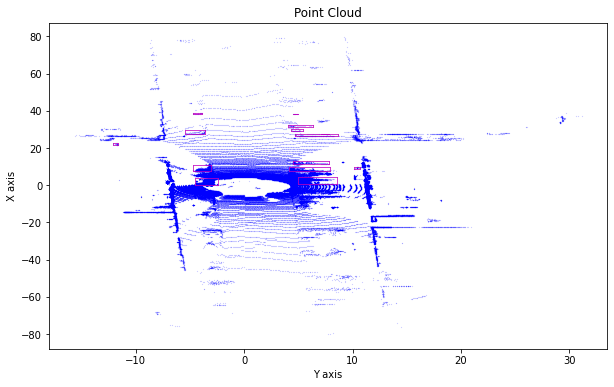

In [359]:
%matplotlib inline
f = plt.figure(figsize=(10, 6))
axes = [1,0]
# ax = f.add_subplot(111, projection='3d') 
ax = f.add_subplot(111) 
draw.draw_point_cloud(scan, ax, 'Point Cloud',axes=axes, 
                      axes_str = ['X', 'Y', 'Z'], )
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

In [1056]:
pcloud = pd.DataFrame(np.concatenate((scan, label.reshape(len(label), 1)), axis=1), 
                                                    columns=['x', 'y', 'z', 'seg_id'])
%time cloud = common.obstacle_filter(pcloud, obstacle_lst)

Filter required segments
Point size before: 119053 and after filtering: 19133
CPU times: user 250 ms, sys: 64 µs, total: 250 ms
Wall time: 251 ms


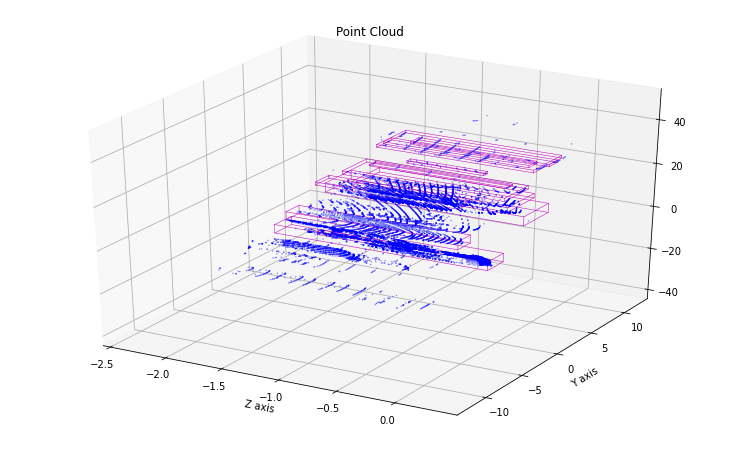

In [1057]:
%matplotlib inline
spoints = cloud[['x','y','z']]
f = plt.figure(figsize=(13, 8))
axes = [2,1,0]
ax = f.add_subplot(111, projection='3d') 
draw.draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes, axes_str=['X', 'Y', 'Z'])
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

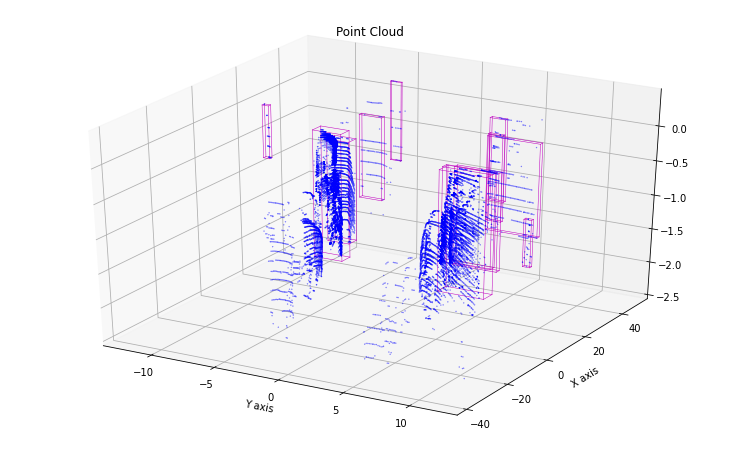

In [1058]:
%matplotlib inline
spoints = cloud[['x','y','z']]
f = plt.figure(figsize=(13, 8))
axes = [1,0,2]
ax = f.add_subplot(111, projection='3d') 
draw.draw_point_cloud(spoints.values, ax, 'Point Cloud',axes=axes, axes_str=['X', 'Y', 'Z'])
for box in box_coord_list:
     draw.draw_box(ax, box, axes=axes, color='m')

## Grid Search Optimization

In [1485]:
help(test.grid_search_optimization)

Help on function grid_search_optimization in module scripts.test:

grid_search_optimization(scan, label, obstacle_lst, pipeline, params, verbose=True)
    Grid Search of hyperparametrs for optimization of executional time of pipeline
    
    scan: numpy.array,
    An N X 3 array of point cloud from LIDAR
    
    label: numpy.array,
    A list of segmentation labels respectively
    
    obstacle_lst: list,
    A list of obstacles id
    
    pipeline: function,
    An obstacle-detection pipeline function
    
    params: dict,
    A dictionary of params range that is reqired to search
    
    verbose: bool, optional, defualt True
    Whether or not print info during execution.



In [38]:
from scripts import test
test = imp.reload(test)
range_params  = { 'roi_x_min': [0], 'roi_x_max': [45],
                  'roi_y_min': [-14], 'roi_y_max': [14],
                  'roi_z_min': [-2], 'roi_z_max': [1],
                  'eps': [0.5, 0.55, 0.65, 0.7], 'min_samples': [4, 5, 6, 7, 8], 
                  'leaf_size': [75, 100, 120, 150, 200, 300]}  
time_exec_lst = test.grid_search_optimization(scan, label, obstacle_lst, pipeline, 
                                              range_params, score=True, verbose=False)

In [39]:
time_ex_lst = {k: v  for k, v in time_exec_lst.items() if v[-1] > 0.55} 
sorted_exec_dct = {k: v for k, v in sorted(time_ex_lst.items(), key=lambda item: item[1][0], reverse=False)}

In [40]:
n = 10
for i, key in enumerate(sorted_exec_dct):
    if i == n:
        break
    print(key,'Time and n clusters', sorted_exec_dct[key])

{
   "eps": 0.7,
   "leaf_size": 300,
   "min_samples": 8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 14,
   "roi_y_min": -14,
   "roi_z_max": 1,
   "roi_z_min": -2
} Time and n clusters (0.739776, 12, 0.7007078841388615)
{
   "eps": 0.7,
   "leaf_size": 200,
   "min_samples": 6,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 14,
   "roi_y_min": -14,
   "roi_z_max": 1,
   "roi_z_min": -2
} Time and n clusters (0.77401, 12, 0.7007078841388615)
{
   "eps": 0.7,
   "leaf_size": 200,
   "min_samples": 4,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 14,
   "roi_y_min": -14,
   "roi_z_max": 1,
   "roi_z_min": -2
} Time and n clusters (0.814028, 12, 0.7007078841388615)
{
   "eps": 0.7,
   "leaf_size": 100,
   "min_samples": 8,
   "roi_x_max": 45,
   "roi_x_min": 0,
   "roi_y_max": 14,
   "roi_y_min": -14,
   "roi_z_max": 1,
   "roi_z_min": -2
} Time and n clusters (0.8159510000000001, 12, 0.7007078841388615)
{
   "eps": 0.7,
   "leaf_size": 120,
   "min_samples":

### Getting bounding boxes and grep statistics for sequence 

In [53]:
import glob
seq = '01'
scan_lst = sorted(glob.glob("../dataset/sequences/" + seq + "/velodyne/*.bin"))
labels_lst = sorted(glob.glob("../dataset/sequences/" + seq + "/labels/*.label"))
assert len(scan_lst) == len(labels_lst)
print('READ OK, number of scans ', len(scan_lst))

READ OK, number of scans  144


In [54]:
from scripts import test
test = imp.reload(test)

In [55]:
%%time
# n_scan = -1
# write_path = '../dataset/sequences/' + seq + '/clusters/'
write_path = None
bbox_dct, exec_time_dct, stats = test.get_bbox_and_stat(scan_lst, labels_lst, obstacle_lst,
                                                        pipeline, write_path=write_path, 
                                                        write_rotated=False, detailed=True, **params)


CPU times: user 21.2 s, sys: 1.13 s, total: 22.4 s
Wall time: 30.5 s


In [56]:
steps = list(stats[0].keys())
steps_exec_time = []
for step in steps:
    steps_exec_time.append([stat[step] for stat in stats])

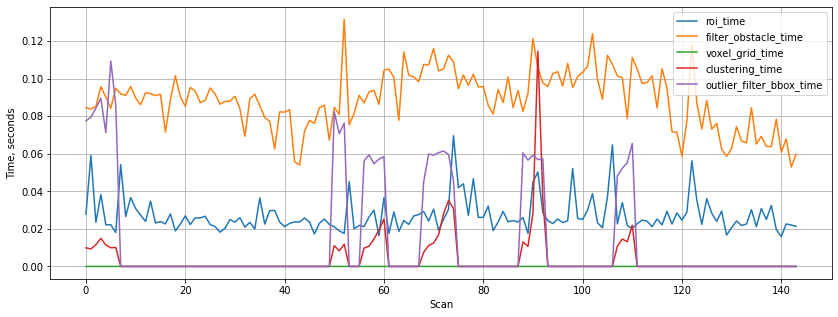

In [57]:
plt.figure(figsize=(14,5))
for i, step in enumerate(steps):
    plt.plot(steps_exec_time[i], label=step)
plt.legend(loc='best')
plt.xlabel('Scan')
plt.ylabel('Time, seconds')
plt.grid()
plt.show()

In [58]:
time_stat = list(exec_time_dct.values())
print('Min process time {} s'.format(min(time_stat)))
print('Mean process time {} s'.format(np.mean(time_stat)))
print('Max process time {} s'.format(max(time_stat)))

Min process time 0.074972 s
Mean process time 0.13439232638888887 s
Max process time 0.327634 s


In [59]:
ox = [int(x) for x in list(exec_time_dct.keys())]
oy = time_stat

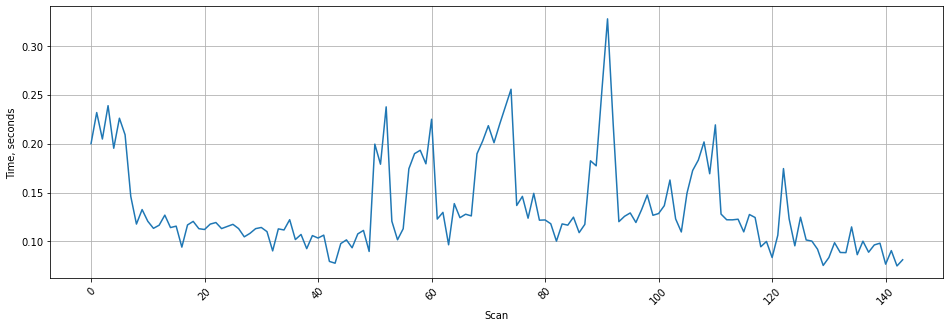

In [60]:
plt.figure(figsize=(16, 5))
plt.plot(ox, oy)
plt.xlabel('Scan')
plt.ylabel('Time, seconds')
plt.grid()
plt.xticks(rotation=45)
plt.show()

### Grep statistics of execution time for several observations

In [32]:
exec_lst = []
n_epoch = 5
for i in range(n_epoch):
    bbox_dct, exec_time_dct, stats = test.get_bbox_and_stat(scan_lst, labels_lst, obstacle_lst,
                                                        pipeline_optimized, write_path=write_path, 
                                                        write_rotated=True, detailed=True, **params)
    exec_lst.append(exec_time_dct)

In [52]:
several_exec_time_lst = [] 
for epoch in exec_lst:
    several_exec_time_lst.append(list(epoch.values()))
several_exec_time_lst = list(zip(several_exec_time_lst[0],
                                 several_exec_time_lst[1],
                                 several_exec_time_lst[2]))

In [64]:
ox = [int(x)for x in exec_lst[0].keys()]
oy_mean = [np.mean(exec_times) for exec_times in several_exec_time_lst]
oy_min = [min(exec_times) for exec_times in several_exec_time_lst]
oy_max = [max(exec_times) for exec_times in several_exec_time_lst]

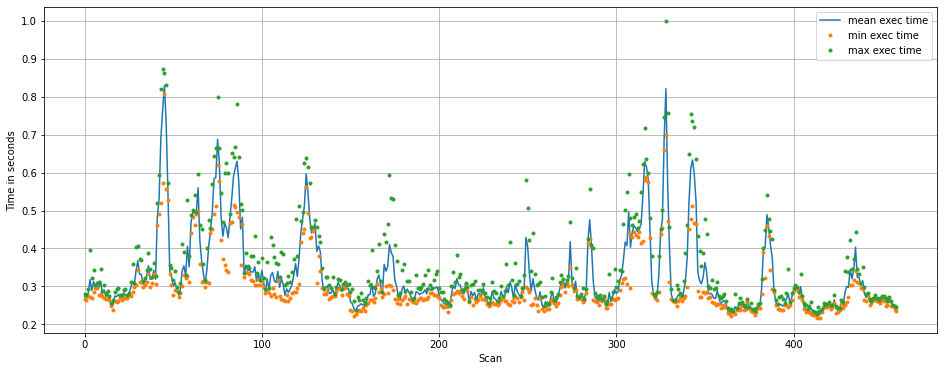

In [68]:
plt.figure(figsize=(16, 6))
plt.plot(ox, oy_mean, label='mean exec time')
plt.plot(ox, oy_min, '.', label='min exec time')
plt.plot(ox, oy_max, '.', label='max exec time')
plt.xlabel('Scan')
plt.ylabel('Time, seconds')
plt.grid()
plt.legend()
plt.show()